<h1 style="text-align: center;">Object tracking in EM images using Morphological Geodesic Active Contours (MGAC)</h1>

Morphological Geodesic Active Contour (MGAC) tracker for binary object segmentation in 2D frame sequences.  
Supports intensity+edge fusion, ROI-limited evolution, leak guard, and robust re-acquisition.

### Features
- Per-frame segmentation of sequences (tracking mode or per-frame GT seeding)
- Intensity fusion (adaptive/global) and edge-stopping via inverse Gaussian gradient
- Leak guard and local/global re-acquire
- Metrics: IoU, Dice, Pixel Accuracy/Error
- Visualization: per-frame metrics plot, example overlays, surface-distance analysis (ASSD/HD95)

#### Author
- Mobina Azimi, M.Sc
- Email:mobinaazimi999@gmail.com

### Import Required Modules
Load necessary libraries including NumPy, matplotlib, skimage, and the custom `MGAC` class for segmentation.

In [1]:
# Import the MGAC class
from juspice.object_tracking.mgac import MGAC

### Scenario A: EM-like single cluster, smooth growth/shrink 


In [ ]:
model = MGAC(
    syn_dir= DATA / "synthetic_image",
    msk_dir= DATA / "masks_SK",   
    pred_mask_dir= OUTPUT/ "pred_masks",
    results_dir= OUTPUT /"results",

    width=256,
    height=256,
    n_frames=200,

    mgac_smooth=2,
    mgac_balloon=0.20,   # outward push for faint edges
    mgac_thresh=0.30,    # lower = cross weaker edges
    mgac_iters=150,

    min_area=120,        # minimum particle area
    top_k=1,             # track one object

    fg_bright=False,     # EM particles usually darker
    init_offset=0.10,
    block_size=51,

    debug_visuals=False,
    init_mode="track"    
)

# Optional: tighten or loosen tracking constraints
model.max_jump_px = 12
model.area_ratio_lo = 0.6
model.area_ratio_hi = 1.5

Run MGAC on Scenario A

In [4]:
model.run()

2025-09-25 07:29:13,364 - INFO - MGAC segmentation started.
2025-09-25 07:35:28,986 - INFO - MGAC segmentation finished.


Plot metrics and print averages

- Plot contains Dice, IoU, and Pixel Accuracy per frame.

- Examples overlay predicted contours for a few frames.

- assert_results() sanity-checks lengths/ranges and mask sizes.

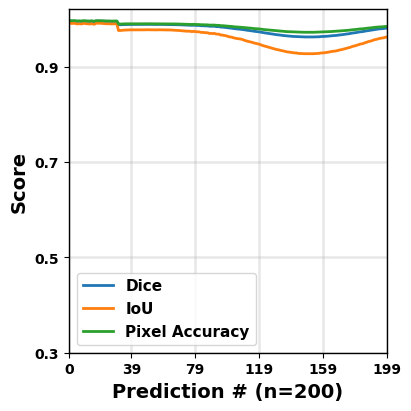

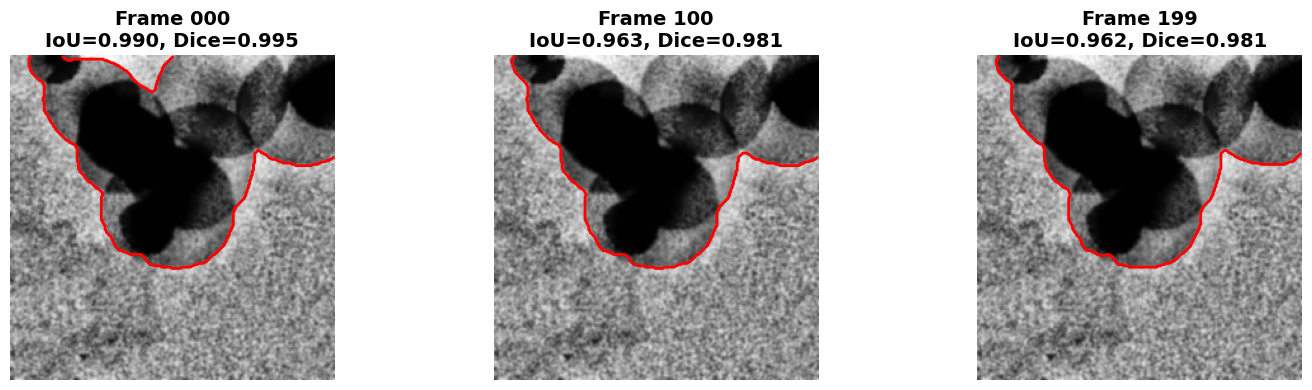

All assertions passed.
MGAC segmentation took 6 min 15.6 sec.

=== Overall Averages (vs Ground Truth) ===
Average Pixel Accuracy: 0.9840
Average Pixel Error:     0.0160
Average IoU (Jaccard):             0.9604
Average Dice score:                0.9797
Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/Results_mgac_track_12/compare_1x4_t000.png


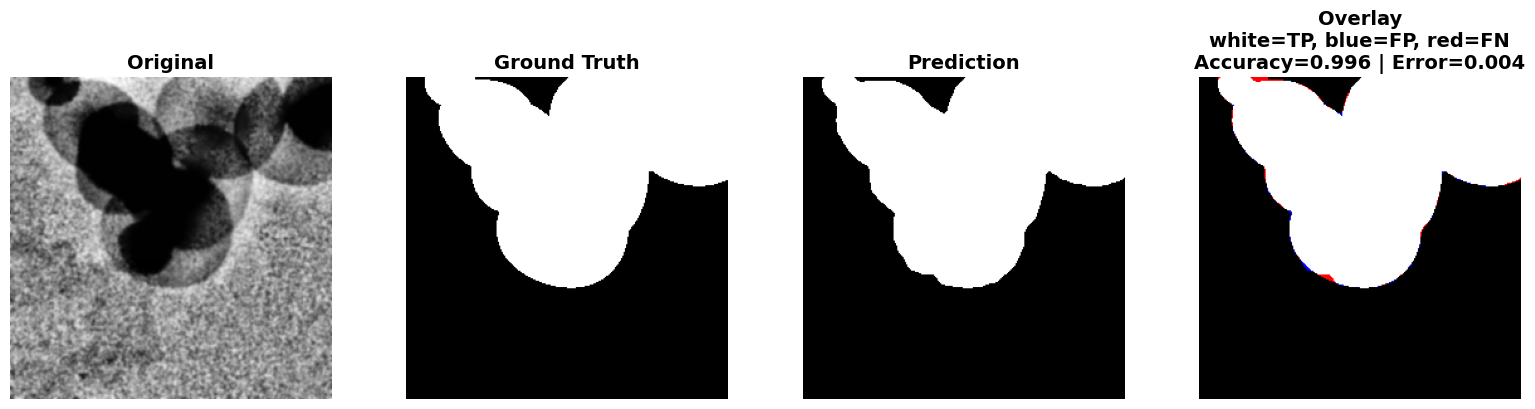

Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/Results_mgac_track_12/compare_1x4_t100.png


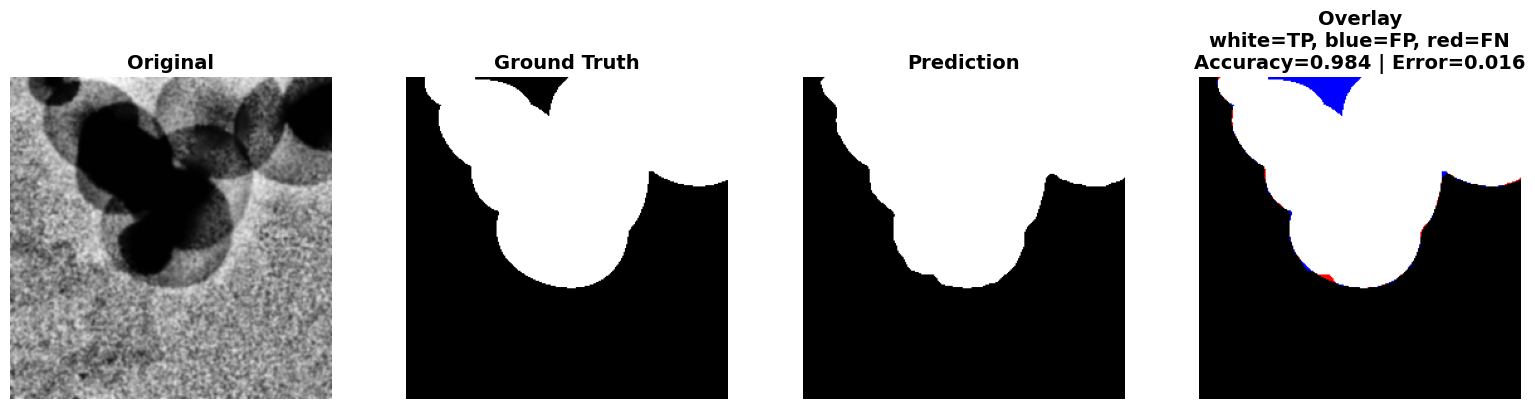

Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/Results_mgac_track_12/compare_1x4_t199.png


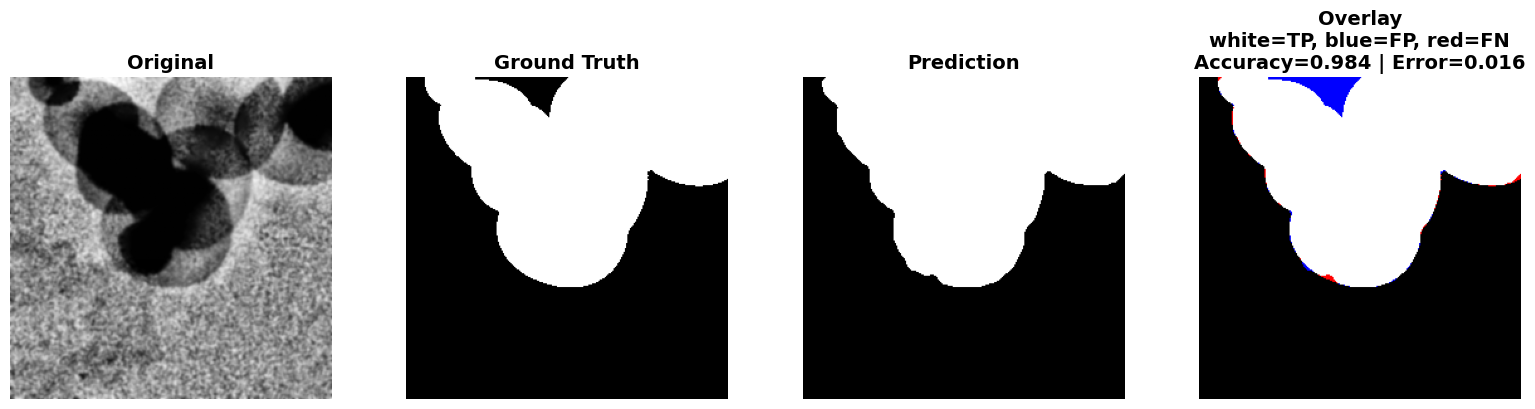

In [5]:
model.plot_performance()
model.show_examples()
model.assert_results()
model.evaluate()

Surface distance analysis (ASSD & HD95)

- Computes signed distances (under/over-seg) and symmetric distances.

- Plots histogram of signed distances (FN=negative, FP=positive).

- Plots time series of mean signed, ASSD, and HD95 per frame.

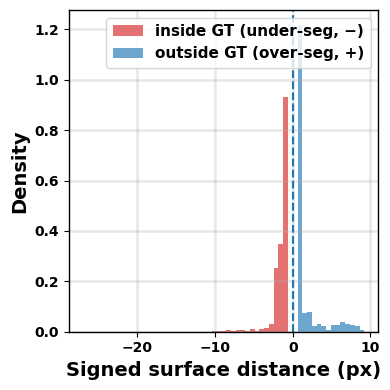

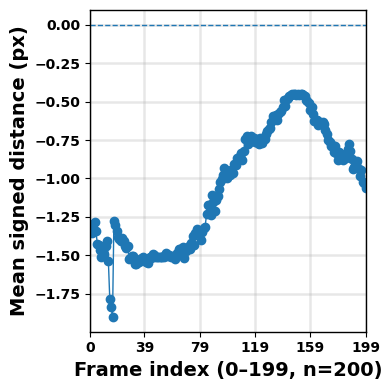

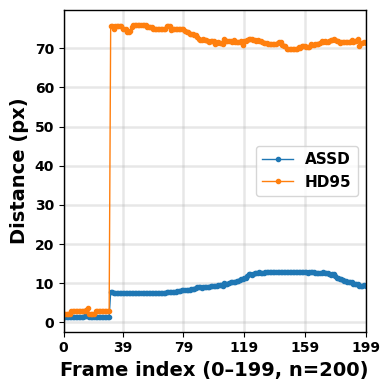

[SUMMARY over 200 frames] ASSD median=9.292px | HD95 median=71.723px | mean signed (overall)=-1.061px


In [6]:
# ==== Surface-distance evaluation (histogram + time series) — MGAC ====
import numpy as np, cv2, matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt as edt

def signed_dt(mask_bin: np.ndarray) -> np.ndarray:
    """
    Signed distance transform of a binary mask (1=FG).
    sdt = edt(~m) - edt(m):
      negative -> inside GT (under-seg)
      positive -> outside GT (over-seg)
    """
    m = mask_bin.astype(bool)
    d_out = edt(~m)
    d_in  = edt(m)
    return d_out - d_in

def boundary(mask_bin: np.ndarray) -> np.ndarray:
    k = np.ones((3,3), np.uint8)
    er = cv2.erode(mask_bin.astype(np.uint8), k, iterations=1)
    return (mask_bin.astype(np.uint8) ^ er).astype(np.uint8)

def hausdorff95(sym_dists_abs: np.ndarray) -> float:
    return np.nan if sym_dists_abs.size == 0 else float(np.percentile(sym_dists_abs, 95))

def assd_from_sym(sym_dists_abs: np.ndarray) -> float:
    return np.nan if sym_dists_abs.size == 0 else float(np.mean(sym_dists_abs))

# --- gather arrays from MGAC (run model.run() first) ---
assert hasattr(model, "masks") and len(model.masks) > 0, "Run model.run() first."
assert hasattr(model, "gt_masks") and len(model.gt_masks) > 0, "Ground-truth masks missing."

PRED = [m.astype(np.uint8) for m in model.masks]     # (H,W) in {0,1}
GT   = [g.astype(np.uint8) for g in model.gt_masks]  # (H,W) in {0,1}
n = min(len(PRED), len(GT))
sel = list(range(n))  # evaluate all overlapping frames

all_signed = []
ts_mean_signed, ts_assd, ts_hd95, ts_idx = [], [], [], []

for i in sel:
    pred_b = PRED[i]
    gt_bin = GT[i]

    # shape safety
    if pred_b.shape != gt_bin.shape:
        pred_b = cv2.resize(pred_b, (gt_bin.shape[1], gt_bin.shape[0]), interpolation=cv2.INTER_NEAREST)

    # distances: pred→GT (signed) & GT↔pred (symmetric absolute)
    sdt_gt = signed_dt(gt_bin)
    Bp = boundary(pred_b)
    signed_pred_to_gt = sdt_gt[Bp > 0]  # <0 inside GT (under), >0 outside GT (over)

    sdt_pred = signed_dt(pred_b)
    Bg = boundary(gt_bin)
    abs_gt_to_pred = np.abs(sdt_pred[Bg > 0])
    abs_pred_to_gt = np.abs(signed_pred_to_gt)
    if abs_gt_to_pred.size or abs_pred_to_gt.size:
        sym_abs = np.concatenate([abs_gt_to_pred, abs_pred_to_gt], axis=0)
    else:
        sym_abs = np.array([])

    if signed_pred_to_gt.size:
        all_signed.append(signed_pred_to_gt)
        ts_mean_signed.append(float(np.mean(signed_pred_to_gt)))
    else:
        ts_mean_signed.append(np.nan)

    ts_assd.append(assd_from_sym(sym_abs))
    ts_hd95.append(hausdorff95(sym_abs))
    ts_idx.append(i)  # MGAC uses sequential frames

if not all_signed:
    raise RuntimeError("No boundary pixels collected. Check masks or thresholds.")
all_signed = np.concatenate(all_signed, axis=0)

# 1) Signed distance histogram
plt.figure(figsize=(4.0,4.0))
neg = all_signed[all_signed < 0]     # inside GT  -> under-seg
pos = all_signed[all_signed >= 0]    # outside GT -> over-seg
bins = np.linspace(min(-5, np.min(all_signed)), max(5, np.max(all_signed)), 60)

FP_COLOR = '#1f77b4'   # blue  (outside GT → FP / over-seg / +)
FN_COLOR = '#d62728'   # red   (inside GT  → FN / under-seg / −)
plt.hist(neg, bins=bins, alpha=0.65, label="inside GT (under-seg, −)", density=True, color=FN_COLOR)
plt.hist(pos, bins=bins, alpha=0.65, label="outside GT (over-seg, +)", density=True, color=FP_COLOR)
plt.axvline(0, linestyle="--")
plt.xlabel("Signed surface distance (px)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Time series (use true frame indices 0..n-1)
ts_idx         = np.array(ts_idx, dtype=int)
xmin, xmax     = int(ts_idx.min()), int(ts_idx.max())
xticks         = np.linspace(xmin, xmax, 6, dtype=int)
ts_mean_signed = np.array(ts_mean_signed)
ts_assd        = np.array(ts_assd)
ts_hd95        = np.array(ts_hd95)

plt.figure(figsize=(4.0,4.0))
plt.plot(ts_idx, ts_mean_signed, marker='o', linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlim(xmin, xmax); plt.xticks(xticks)
plt.xlabel(f"Frame index ({xmin}–{xmax}, n={len(ts_idx)})")
plt.ylabel("Mean signed distance (px)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(4.0,4.0))
plt.plot(ts_idx, ts_assd, marker='.', linewidth=1, label="ASSD")
plt.plot(ts_idx, ts_hd95, marker='.', linewidth=1, label="HD95")
plt.xlim(xmin, xmax); plt.xticks(xticks)
plt.xlabel(f"Frame index ({xmin}–{xmax}, n={len(ts_idx)})")
plt.ylabel("Distance (px)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

print(f"[SUMMARY over {len(sel)} frames] "
      f"ASSD median={np.nanmedian(ts_assd):.3f}px | "
      f"HD95 median={np.nanmedian(ts_hd95):.3f}px | "
      f"mean signed (overall)={np.nanmean(ts_mean_signed):.3f}px")

### Scenario B: Three separated clusters in different parts of the image (smooth change)

2025-08-29 14:21:18,672 - INFO - MGAC segmentation started.
2025-08-29 14:51:39,795 - INFO - MGAC segmentation finished.


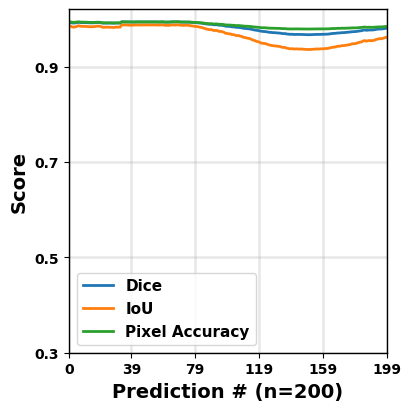

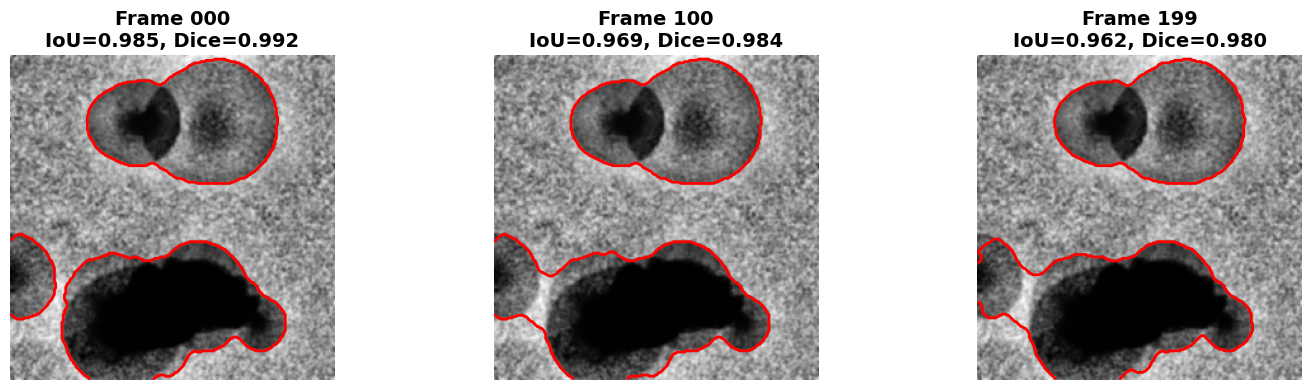

All assertions passed.
MGAC segmentation took 30 min 21.1 sec.

=== Overall Averages (vs Ground Truth) ===
Average Pixel Accuracy: 0.9869
Average Pixel Error:     0.0131
Average IoU (Jaccard):             0.9658
Average Dice score:                0.9825
Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/Results_mgac_track_3/compare_1x4_t000.png


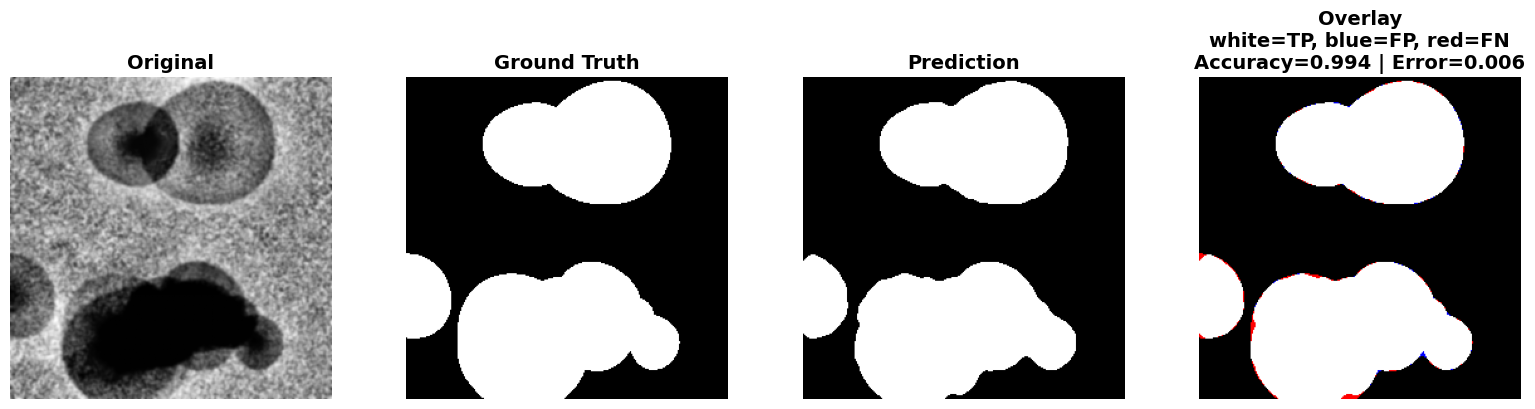

Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/Results_mgac_track_3/compare_1x4_t100.png


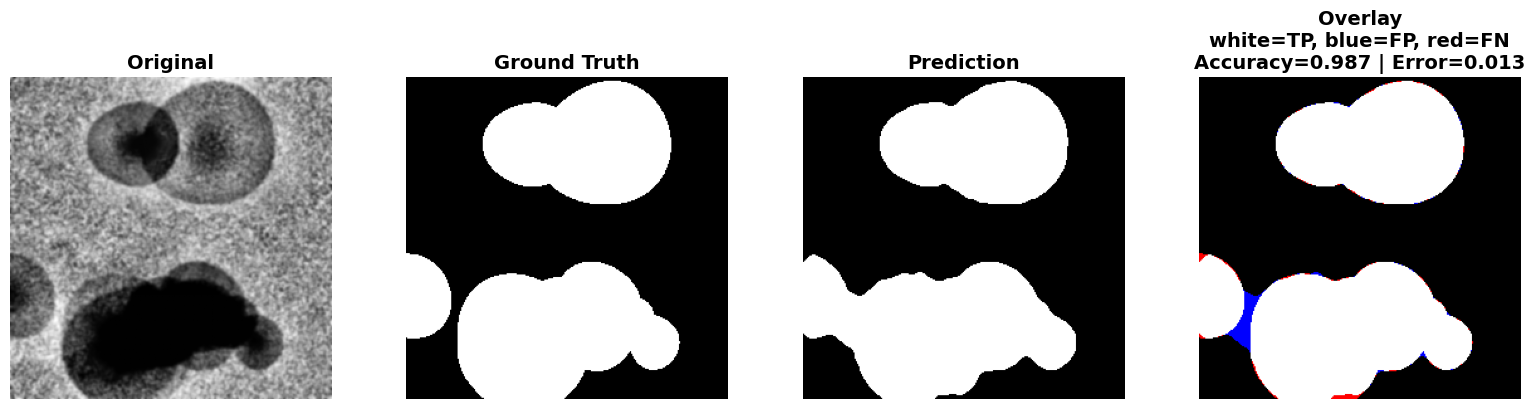

Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/Results_mgac_track_3/compare_1x4_t199.png


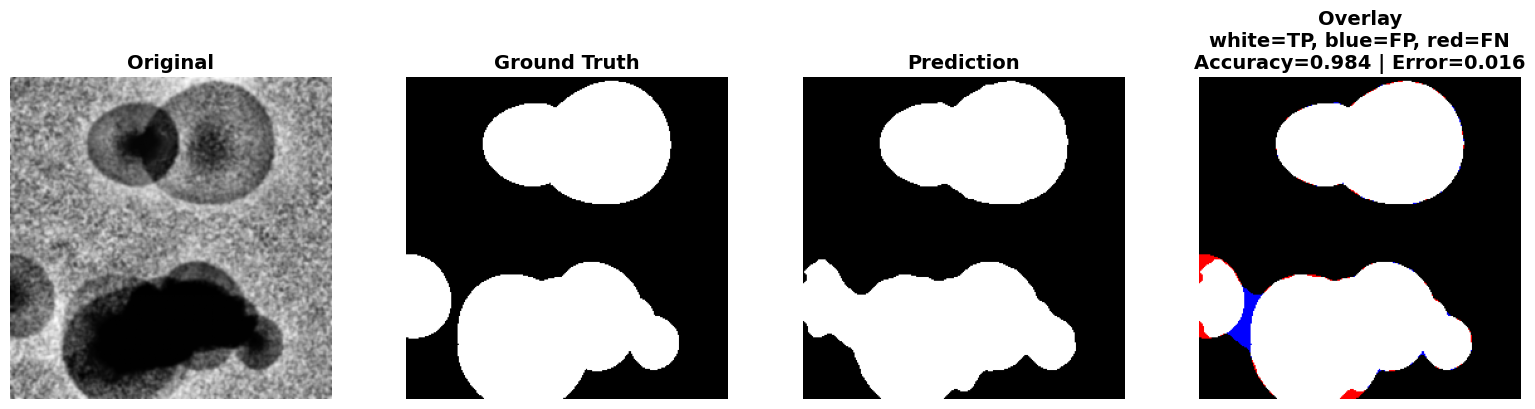

In [ ]:
model = MGAC(
    syn_dir= DATA / "synthetic_image",
    msk_dir=DATA / "masks_Sk",
    pred_mask_dir= OUTPUT / "pred_masks",
    results_dir= OUTPUT / "results",
    width=256, height=256, n_frames=200,

    # MGAC evolution 
    mgac_smooth=4,
    mgac_balloon=0.26,
    mgac_thresh=0.20,
    mgac_iters=250,

    # morphology / selection
    min_area=400,
    top_k=3,
    closing_radius=2,

    # intensity fusion – seeds should be inclusive, not razor-thin
    use_intensity=True,
    intensity_method="adaptive",
    intensity_combine="union",
    fg_bright=True,          # flip to False + set prefer_darker=True if FG is darker
    init_offset=0.06,
    block_size=41,

    # ROI & leak guard
    evolve_roi_pad=56,
    area_leak_frac=0.35,

    debug_visuals=False,
    init_mode="track"
)

# looser, longer-range tracking
model.track_roi_pad = 48
model.max_jump_px   = 30
model.area_ratio_lo = 0.15
model.area_ratio_hi = 3.5
model.prefer_darker = False  # set True if fg_bright=False



# run / report
model.run()
model.plot_performance()
model.show_examples()
model.assert_results()
model.evaluate()


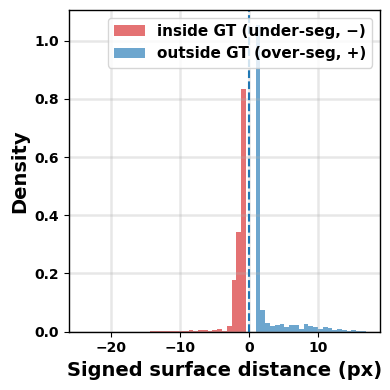

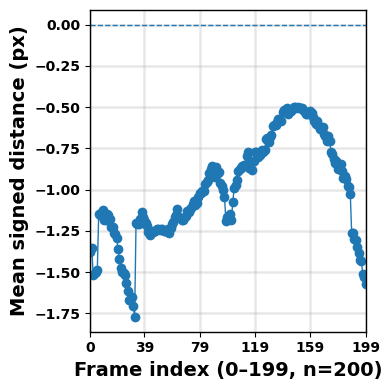

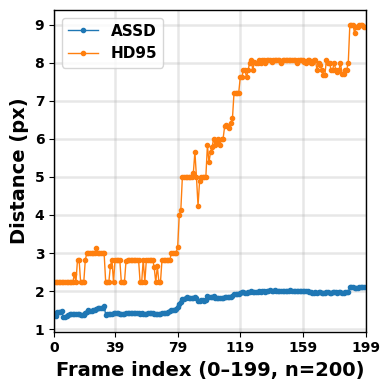

[SUMMARY over 200 frames] ASSD median=1.827px | HD95 median=5.726px | mean signed (overall)=-1.003px


In [14]:
# ==== Surface-distance evaluation (histogram + time series) — MGAC ====
import numpy as np, cv2, matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt as edt

def signed_dt(mask_bin: np.ndarray) -> np.ndarray:
    """
    Signed distance transform of a binary mask (1=FG).
    sdt = edt(~m) - edt(m):
      negative -> inside GT (under-seg)
      positive -> outside GT (over-seg)
    """
    m = mask_bin.astype(bool)
    d_out = edt(~m)
    d_in  = edt(m)
    return d_out - d_in

def boundary(mask_bin: np.ndarray) -> np.ndarray:
    k = np.ones((3,3), np.uint8)
    er = cv2.erode(mask_bin.astype(np.uint8), k, iterations=1)
    return (mask_bin.astype(np.uint8) ^ er).astype(np.uint8)

def hausdorff95(sym_dists_abs: np.ndarray) -> float:
    return np.nan if sym_dists_abs.size == 0 else float(np.percentile(sym_dists_abs, 95))

def assd_from_sym(sym_dists_abs: np.ndarray) -> float:
    return np.nan if sym_dists_abs.size == 0 else float(np.mean(sym_dists_abs))

# --- gather arrays from MGAC (run model.run() first) ---
assert hasattr(model, "masks") and len(model.masks) > 0, "Run model.run() first."
assert hasattr(model, "gt_masks") and len(model.gt_masks) > 0, "Ground-truth masks missing."

PRED = [m.astype(np.uint8) for m in model.masks]     # (H,W) in {0,1}
GT   = [g.astype(np.uint8) for g in model.gt_masks]  # (H,W) in {0,1}
n = min(len(PRED), len(GT))
sel = list(range(n))  # evaluate all overlapping frames

all_signed = []
ts_mean_signed, ts_assd, ts_hd95, ts_idx = [], [], [], []

for i in sel:
    pred_b = PRED[i]
    gt_bin = GT[i]

    # shape safety
    if pred_b.shape != gt_bin.shape:
        pred_b = cv2.resize(pred_b, (gt_bin.shape[1], gt_bin.shape[0]), interpolation=cv2.INTER_NEAREST)

    # distances: pred→GT (signed) & GT↔pred (symmetric absolute)
    sdt_gt = signed_dt(gt_bin)
    Bp = boundary(pred_b)
    signed_pred_to_gt = sdt_gt[Bp > 0]  # <0 inside GT (under), >0 outside GT (over)

    sdt_pred = signed_dt(pred_b)
    Bg = boundary(gt_bin)
    abs_gt_to_pred = np.abs(sdt_pred[Bg > 0])
    abs_pred_to_gt = np.abs(signed_pred_to_gt)
    if abs_gt_to_pred.size or abs_pred_to_gt.size:
        sym_abs = np.concatenate([abs_gt_to_pred, abs_pred_to_gt], axis=0)
    else:
        sym_abs = np.array([])

    if signed_pred_to_gt.size:
        all_signed.append(signed_pred_to_gt)
        ts_mean_signed.append(float(np.mean(signed_pred_to_gt)))
    else:
        ts_mean_signed.append(np.nan)

    ts_assd.append(assd_from_sym(sym_abs))
    ts_hd95.append(hausdorff95(sym_abs))
    ts_idx.append(i)  # MGAC uses sequential frames

if not all_signed:
    raise RuntimeError("No boundary pixels collected. Check masks or thresholds.")
all_signed = np.concatenate(all_signed, axis=0)

# 1) Signed distance histogram
plt.figure(figsize=(4.0,4.0))
neg = all_signed[all_signed < 0]     # inside GT  -> under-seg
pos = all_signed[all_signed >= 0]    # outside GT -> over-seg
bins = np.linspace(min(-5, np.min(all_signed)), max(5, np.max(all_signed)), 60)

FP_COLOR = '#1f77b4'   # blue  (outside GT → FP / over-seg / +)
FN_COLOR = '#d62728'   # red   (inside GT  → FN / under-seg / −)
plt.hist(neg, bins=bins, alpha=0.65, label="inside GT (under-seg, −)", density=True, color=FN_COLOR)
plt.hist(pos, bins=bins, alpha=0.65, label="outside GT (over-seg, +)", density=True, color=FP_COLOR)
plt.axvline(0, linestyle="--")
plt.xlabel("Signed surface distance (px)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Time series (use true frame indices 0..n-1)
ts_idx         = np.array(ts_idx, dtype=int)
xmin, xmax     = int(ts_idx.min()), int(ts_idx.max())
xticks         = np.linspace(xmin, xmax, 6, dtype=int)
ts_mean_signed = np.array(ts_mean_signed)
ts_assd        = np.array(ts_assd)
ts_hd95        = np.array(ts_hd95)

plt.figure(figsize=(4.0,4.0))
plt.plot(ts_idx, ts_mean_signed, marker='o', linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlim(xmin, xmax); plt.xticks(xticks)
plt.xlabel(f"Frame index ({xmin}–{xmax}, n={len(ts_idx)})")
plt.ylabel("Mean signed distance (px)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(4.0,4.0))
plt.plot(ts_idx, ts_assd, marker='.', linewidth=1, label="ASSD")
plt.plot(ts_idx, ts_hd95, marker='.', linewidth=1, label="HD95")
plt.xlim(xmin, xmax); plt.xticks(xticks)
plt.xlabel(f"Frame index ({xmin}–{xmax}, n={len(ts_idx)})")
plt.ylabel("Distance (px)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

print(f"[SUMMARY over {len(sel)} frames] "
      f"ASSD median={np.nanmedian(ts_assd):.3f}px | "
      f"HD95 median={np.nanmedian(ts_hd95):.3f}px | "
      f"mean signed (overall)={np.nanmean(ts_mean_signed):.3f}px")

### Scenario C: Multi-particle, large motion/size changes

2025-08-29 14:52:12,996 - INFO - MGAC segmentation started.
2025-08-29 15:27:54,894 - INFO - MGAC segmentation finished.


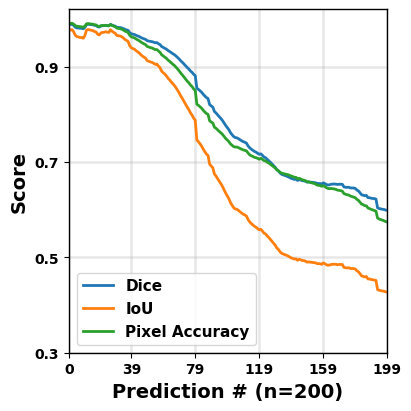

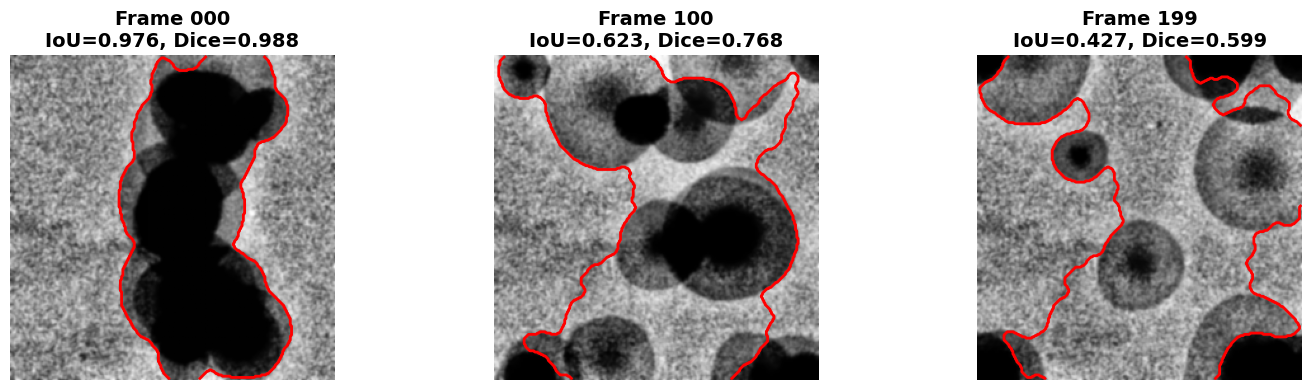

All assertions passed.
MGAC segmentation took 35 min 41.9 sec.

=== Overall Averages (vs Ground Truth) ===
Average Pixel Accuracy: 0.7884
Average Pixel Error:     0.2116
Average IoU (Jaccard):             0.6911
Average Dice score:                0.8006
Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/Results_mgac_track_62/compare_1x4_t000.png


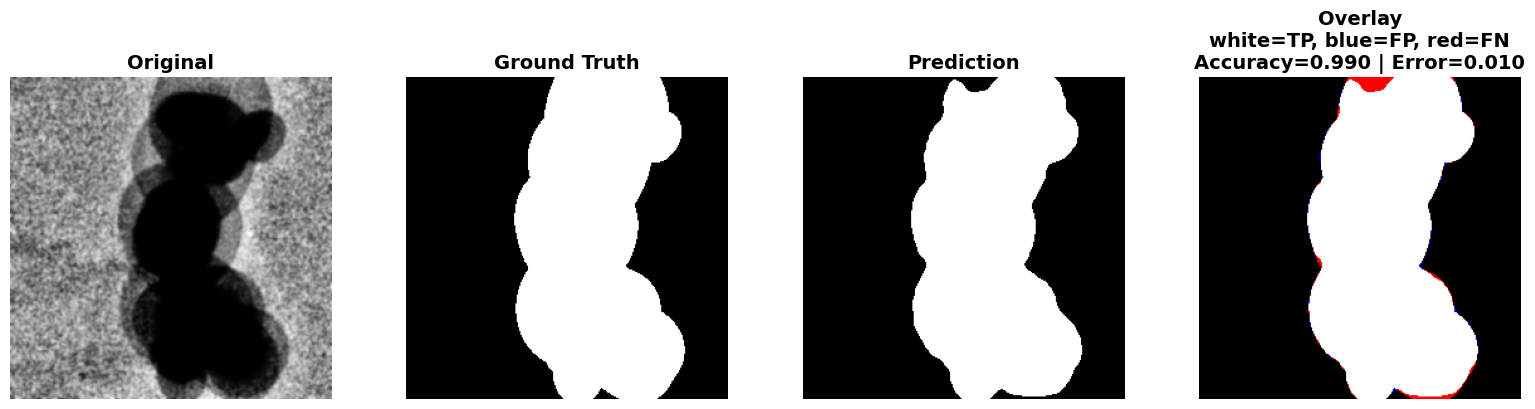

Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/Results_mgac_track_62/compare_1x4_t100.png


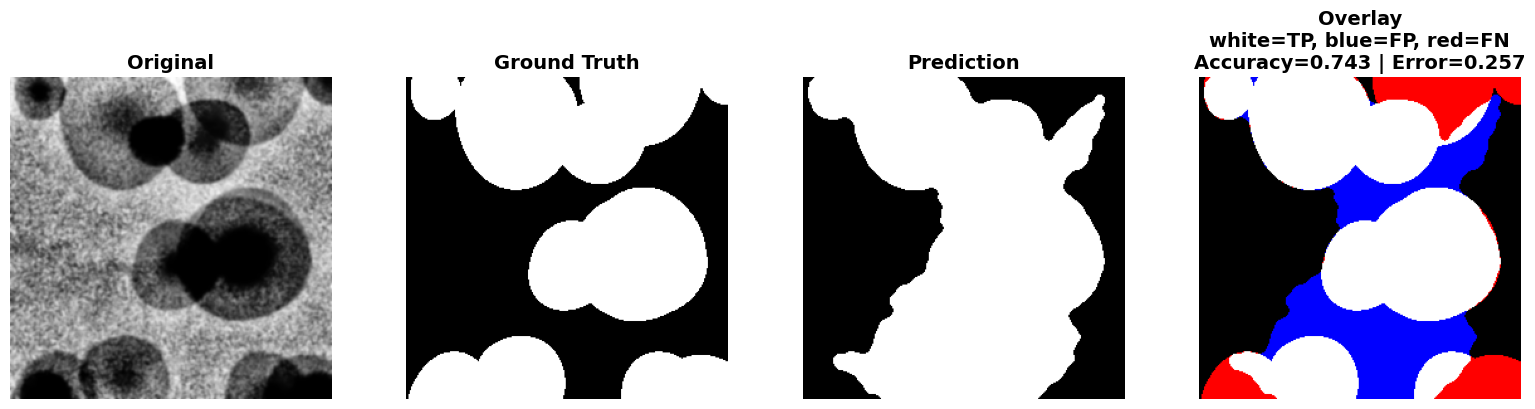

Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/Results_mgac_track_62/compare_1x4_t199.png


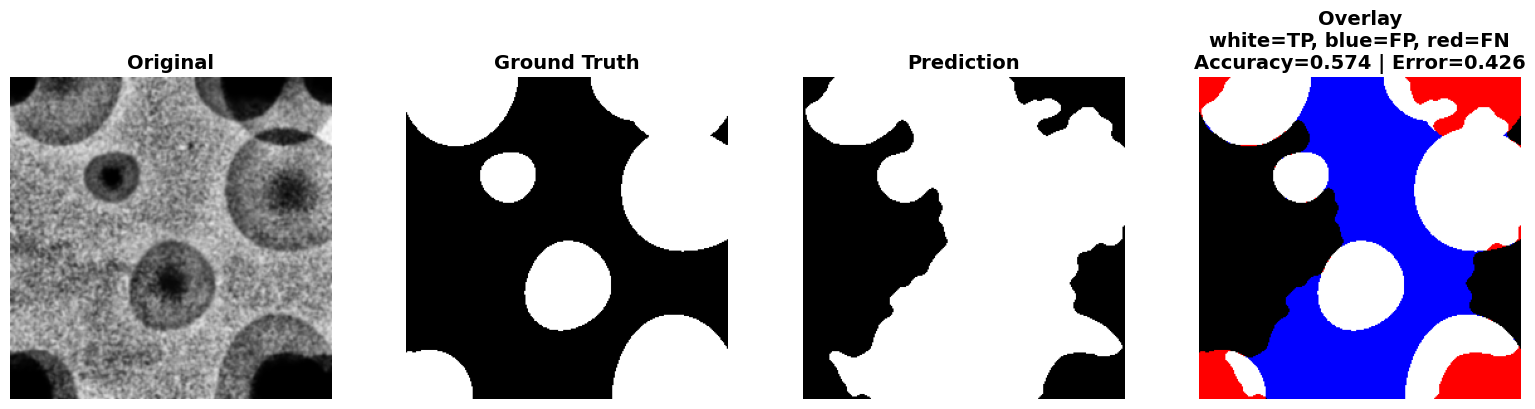

In [ ]:
model = MGAC(
    syn_dir= DATA / "synthetic_image",
    msk_dir= DATA / "masks_SK",
    pred_mask_dir=OUTPUT / "pred_masks",
    results_dir= OUTPUT / "results",

    width=256, height=256, n_frames=200,

    # --- MGAC evolution (stronger stop + longer run) ---
    mgac_smooth=3,
    mgac_balloon=0.06,          # push, but not explosive
    mgac_thresh=0.55,           # cross weak/blurred edges
    mgac_iters=400,             # more time to converge when fast motion/blur
    mgac_alpha=50.0,            # stronger edge-stop in inverse_gaussian_gradient
    mgac_edge_sigma=1.6,        # a bit more smoothing before gradient

    # --- morphology / selection ---
    min_area=140,                # keep small particles; drop speckles later
    top_k=12,                   # track up to 12 (raise/lower to your dataset)
    closing_radius=1,

    # --- intensity fusion (reacquire-friendly) ---
    fg_bright=False,            # set True only if particles are brighter
    init_offset=0.06,
    block_size=41,
    use_intensity=True,
    intensity_method="adaptive",
    intensity_combine="union",  # easier re-acquire; switch to "intersect" if leaks

    # --- ROI evolution + leak guard ---
    evolve_roi_pad=64,          # allow larger shape drift during evolution
    area_leak_frac=0.45,        # only call it a leak if it grows a LOT

    debug_visuals=False,
    init_mode="track"
)

# --- tracking constraints (allow large jumps and size changes) ---
model.max_jump_px   = 32        # tolerate big inter-frame motion
model.track_roi_pad = 64        # larger search window for motion estimation
model.area_ratio_lo = 0.08      # allow strong shrink
model.area_ratio_hi = 3.0       # allow strong growth
model.prefer_darker = True      # keep if particles are darker (flip if not)

# (run)
model.run()
model.plot_performance()
model.show_examples()
model.assert_results()
model.evaluate()


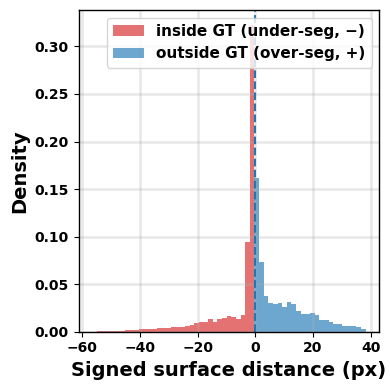

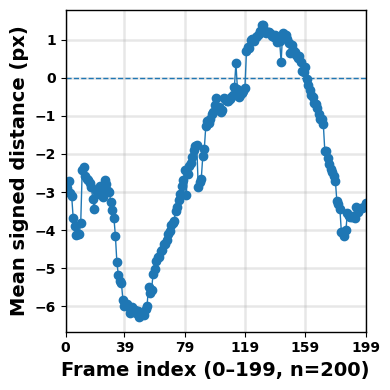

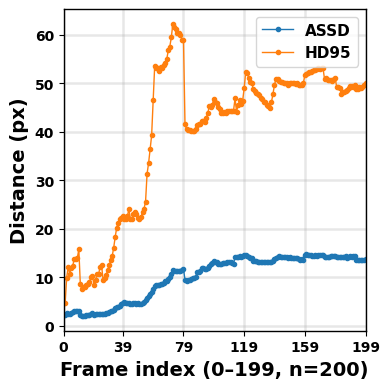

[SUMMARY over 200 frames] ASSD median=12.781px | HD95 median=46.264px | mean signed (overall)=-2.220px


In [16]:
# ==== Surface-distance evaluation (histogram + time series) — MGAC ====
import numpy as np, cv2, matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt as edt

def signed_dt(mask_bin: np.ndarray) -> np.ndarray:
    """
    Signed distance transform of a binary mask (1=FG).
    sdt = edt(~m) - edt(m):
      negative -> inside GT (under-seg)
      positive -> outside GT (over-seg)
    """
    m = mask_bin.astype(bool)
    d_out = edt(~m)
    d_in  = edt(m)
    return d_out - d_in

def boundary(mask_bin: np.ndarray) -> np.ndarray:
    k = np.ones((3,3), np.uint8)
    er = cv2.erode(mask_bin.astype(np.uint8), k, iterations=1)
    return (mask_bin.astype(np.uint8) ^ er).astype(np.uint8)

def hausdorff95(sym_dists_abs: np.ndarray) -> float:
    return np.nan if sym_dists_abs.size == 0 else float(np.percentile(sym_dists_abs, 95))

def assd_from_sym(sym_dists_abs: np.ndarray) -> float:
    return np.nan if sym_dists_abs.size == 0 else float(np.mean(sym_dists_abs))

# --- gather arrays from MGAC (run model.run() first) ---
assert hasattr(model, "masks") and len(model.masks) > 0, "Run model.run() first."
assert hasattr(model, "gt_masks") and len(model.gt_masks) > 0, "Ground-truth masks missing."

PRED = [m.astype(np.uint8) for m in model.masks]     # (H,W) in {0,1}
GT   = [g.astype(np.uint8) for g in model.gt_masks]  # (H,W) in {0,1}
n = min(len(PRED), len(GT))
sel = list(range(n))  # evaluate all overlapping frames

all_signed = []
ts_mean_signed, ts_assd, ts_hd95, ts_idx = [], [], [], []

for i in sel:
    pred_b = PRED[i]
    gt_bin = GT[i]

    # shape safety
    if pred_b.shape != gt_bin.shape:
        pred_b = cv2.resize(pred_b, (gt_bin.shape[1], gt_bin.shape[0]), interpolation=cv2.INTER_NEAREST)

    # distances: pred→GT (signed) & GT↔pred (symmetric absolute)
    sdt_gt = signed_dt(gt_bin)
    Bp = boundary(pred_b)
    signed_pred_to_gt = sdt_gt[Bp > 0]  # <0 inside GT (under), >0 outside GT (over)

    sdt_pred = signed_dt(pred_b)
    Bg = boundary(gt_bin)
    abs_gt_to_pred = np.abs(sdt_pred[Bg > 0])
    abs_pred_to_gt = np.abs(signed_pred_to_gt)
    if abs_gt_to_pred.size or abs_pred_to_gt.size:
        sym_abs = np.concatenate([abs_gt_to_pred, abs_pred_to_gt], axis=0)
    else:
        sym_abs = np.array([])

    if signed_pred_to_gt.size:
        all_signed.append(signed_pred_to_gt)
        ts_mean_signed.append(float(np.mean(signed_pred_to_gt)))
    else:
        ts_mean_signed.append(np.nan)

    ts_assd.append(assd_from_sym(sym_abs))
    ts_hd95.append(hausdorff95(sym_abs))
    ts_idx.append(i)  # MGAC uses sequential frames

if not all_signed:
    raise RuntimeError("No boundary pixels collected. Check masks or thresholds.")
all_signed = np.concatenate(all_signed, axis=0)

# 1) Signed distance histogram
plt.figure(figsize=(4.0,4.0))
neg = all_signed[all_signed < 0]     # inside GT  -> under-seg
pos = all_signed[all_signed >= 0]    # outside GT -> over-seg
bins = np.linspace(min(-5, np.min(all_signed)), max(5, np.max(all_signed)), 60)

FP_COLOR = '#1f77b4'   # blue  (outside GT → FP / over-seg / +)
FN_COLOR = '#d62728'   # red   (inside GT  → FN / under-seg / −)
plt.hist(neg, bins=bins, alpha=0.65, label="inside GT (under-seg, −)", density=True, color=FN_COLOR)
plt.hist(pos, bins=bins, alpha=0.65, label="outside GT (over-seg, +)", density=True, color=FP_COLOR)
plt.axvline(0, linestyle="--")
plt.xlabel("Signed surface distance (px)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Time series (use true frame indices 0..n-1)
ts_idx         = np.array(ts_idx, dtype=int)
xmin, xmax     = int(ts_idx.min()), int(ts_idx.max())
xticks         = np.linspace(xmin, xmax, 6, dtype=int)
ts_mean_signed = np.array(ts_mean_signed)
ts_assd        = np.array(ts_assd)
ts_hd95        = np.array(ts_hd95)

plt.figure(figsize=(4.0,4.0))
plt.plot(ts_idx, ts_mean_signed, marker='o', linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlim(xmin, xmax); plt.xticks(xticks)
plt.xlabel(f"Frame index ({xmin}–{xmax}, n={len(ts_idx)})")
plt.ylabel("Mean signed distance (px)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(4.0,4.0))
plt.plot(ts_idx, ts_assd, marker='.', linewidth=1, label="ASSD")
plt.plot(ts_idx, ts_hd95, marker='.', linewidth=1, label="HD95")
plt.xlim(xmin, xmax); plt.xticks(xticks)
plt.xlabel(f"Frame index ({xmin}–{xmax}, n={len(ts_idx)})")
plt.ylabel("Distance (px)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

print(f"[SUMMARY over {len(sel)} frames] "
      f"ASSD median={np.nanmedian(ts_assd):.3f}px | "
      f"HD95 median={np.nanmedian(ts_hd95):.3f}px | "
      f"mean signed (overall)={np.nanmean(ts_mean_signed):.3f}px")

### Scenario D — Real EM sequence (898 frames) — tracking with sparse labels (5 ground-truth masks).

In [1]:
from juspice.object_tracking.mgac import MGAC

[Setup] frames=898, first-mask area=30155, min_area=1507
[Masks] Using 5 ground-truth masks


2025-08-26 14:29:16,703 - INFO - MGAC segmentation started.


Model ready. Running on 898 frames with intensity+edge seeding...


2025-08-26 14:56:47,108 - INFO - MGAC segmentation finished.


All assertions passed.
MGAC segmentation took 27 min 30.4 sec.

=== Overall Averages (vs GT) ===
Average Pixel Accuracy:  0.7260
Average IoU (Jaccard):   0.4866
Average Dice score:      0.6484
Average Absolute Diff:   0.2740
Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/results_emgac_5gt_intensity/compare_1x4_t000.png


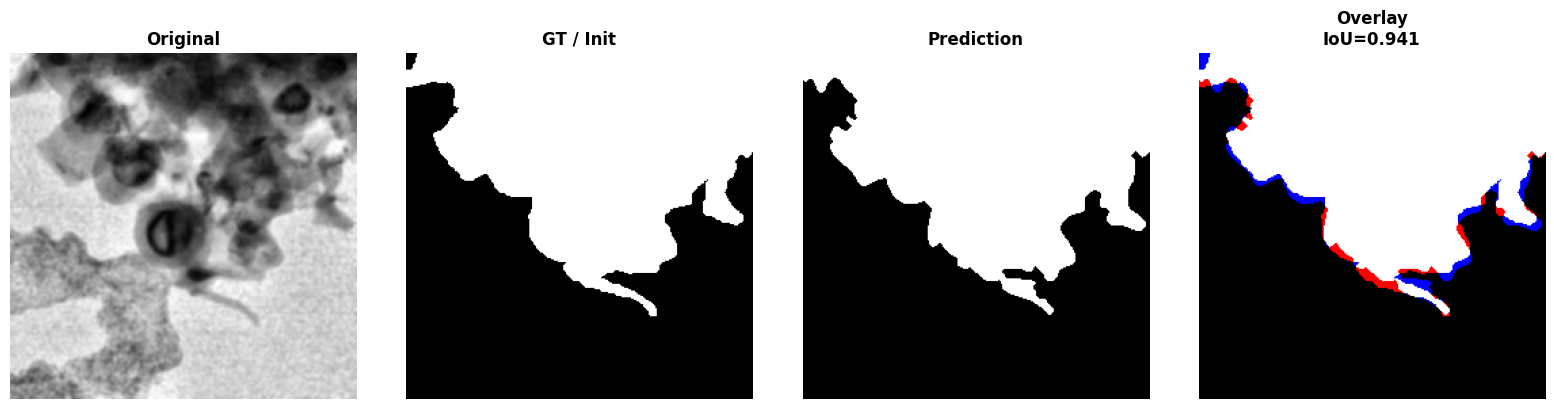

Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/results_emgac_5gt_intensity/compare_1x4_t449.png


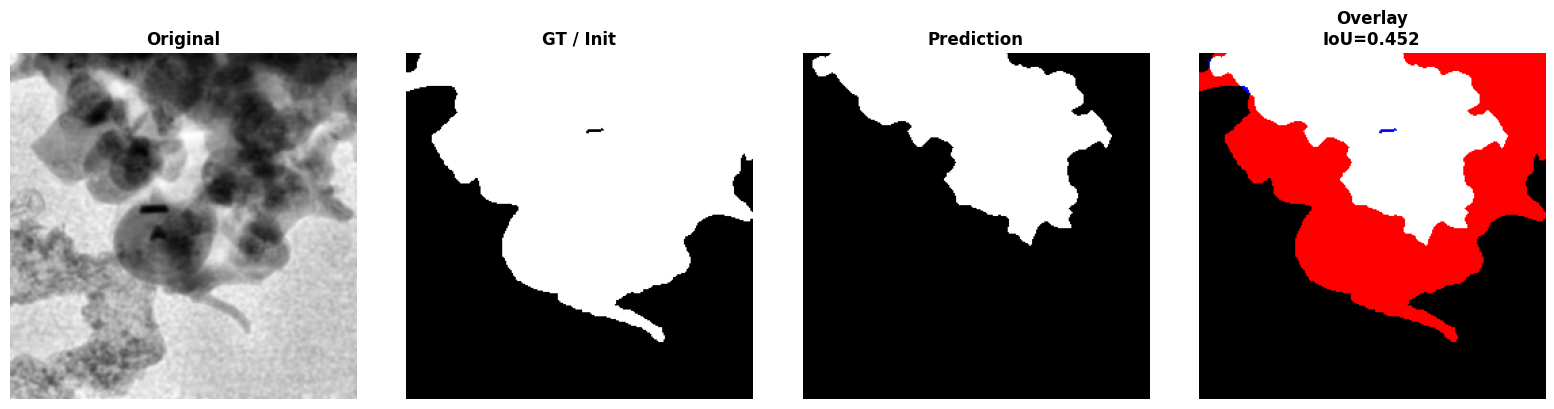

Saved 1×4 comparison to: /mnt/bcache/work/m.azimi/GIT_repositories/juspice/MoAz_data/results_emgac_5gt_intensity/compare_1x4_t897.png


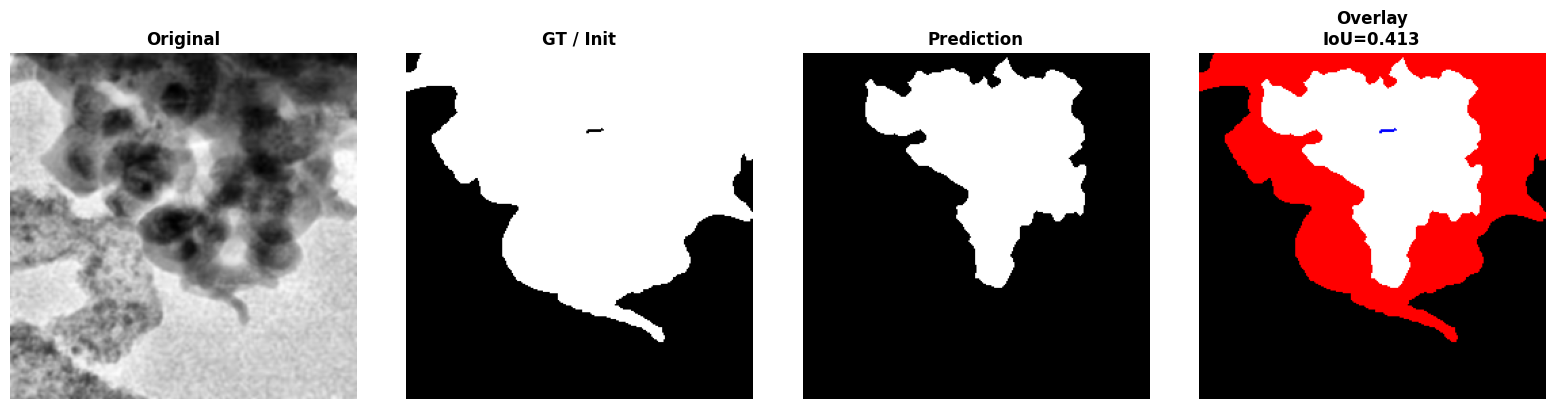

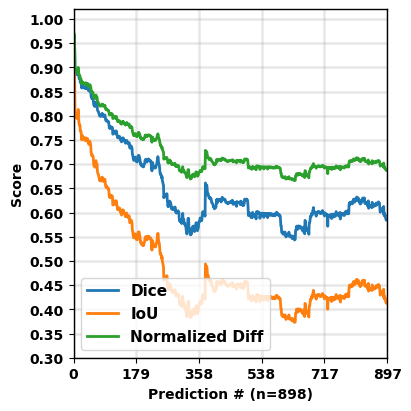

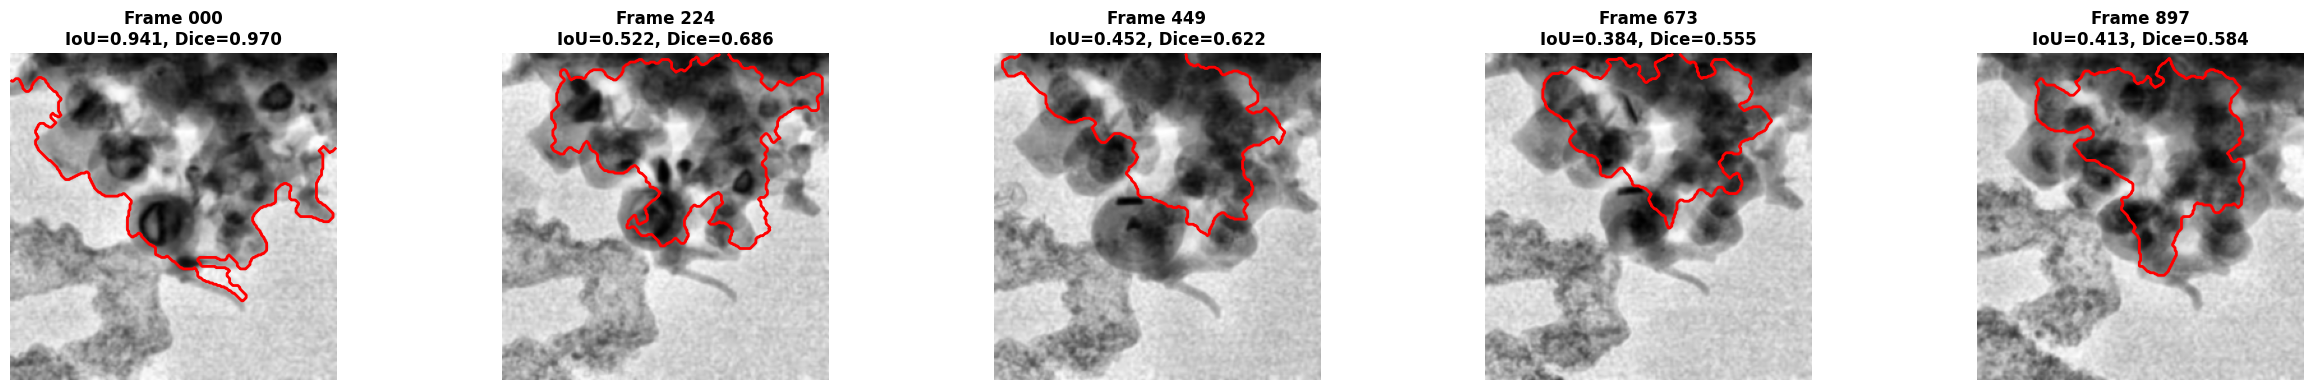

In [ ]:
# --- Cell: Run 898-frame EM dataset using 5 masks ---

from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
import numpy as np
# If you edited the MGAC class file, reload it before use:
# import importlib, juspice.object_tracking.mgac as mgac
# importlib.reload(mgac)
from juspice.object_tracking.mgac import MGAC

# -----------------
# Paths
# -----------------
syn_dir  = Path(".../TiO2_5nm_1/resized_256")  # 898 frames
msk_dir  = Path(".../binary_masks_otsu")       # 5 masks
pred_dir = Path(".../predicted_masks_emgac")
res_dir  = Path(".../results_emgac")

W, H = 256, 256  # resize target

# -----------------
# Frame count
# -----------------
img_files = sorted(
    [*syn_dir.glob("*.png"), *syn_dir.glob("*.jpg"), *syn_dir.glob("*.jpeg"),
     *syn_dir.glob("*.tif"), *syn_dir.glob("*.tiff")],
    key=lambda p: p.name
)
n_frames = len(img_files)
assert n_frames > 0, f"No frames found in {syn_dir}"

# -----------------
# First mask -> estimate min_area
# -----------------
m0_files = sorted(msk_dir.glob("*.png"))
assert len(m0_files) > 0, f"No masks found in {msk_dir}"
m0 = imread(str(m0_files[0]))
if m0.ndim == 3: 
    m0 = m0[..., 0]
m0 = (m0 >= 128)
m0 = resize(m0.astype(float), (H, W), order=0, preserve_range=True).astype(bool)
area0 = int(m0.sum())

# Gentle so we don't delete the object when it shrinks a bit
min_area = max(30, int(0.05 * area0))   # ~5% of first mask

print(f"[Setup] frames={n_frames}, first-mask area={area0}, min_area={min_area}")
print(f"[Masks] Using {len(m0_files)} ground-truth masks")

# -----------------
# Build model (intensity + edge + ROI + fallbacks)
# -----------------
model = MGAC(
    syn_dir=syn_dir,
    msk_dir=msk_dir,
    pred_mask_dir=pred_dir,
    results_dir=res_dir,
    width=W, height=H, n_frames=n_frames,

    # --- Active contour (balanced) ---
    mgac_smooth=1,          # mild smoothing; avoids curvature shrink but stabilizes edges
    mgac_balloon=0.15,      # gentle outward push (between shrinking 0.10 and growing 0.18)
    mgac_thresh=0.38,       # a bit stricter edge stop to prevent sudden growth
    mgac_iters=200,
    mgac_alpha=40.0,
    mgac_edge_sigma=1.0,

    # --- Cleanup / gating ---
    min_area=min_area,
    top_k=1,
    closing_radius=1,

    # --- Intensity cue (use the image, but not too aggressively) ---
    fg_bright=False,
    intensity_method="adaptive",
    intensity_combine="union",  # use OR so we don't shrink
    block_size=51,
    init_offset=0.07,           # slightly lower offset → slightly larger dark seed, but not huge

    # --- ROI + leak guard (moderate) ---
    evolve_roi_pad=40,          # enough room to grow, not too much
    area_leak_frac=0.22,        # trigger leak guard if mask >22% of the frame

    debug_visuals=False,
    init_mode="track"
)

# Tracking constraints (moderate freedom)
model.max_jump_px   = 28        # allow motion but not too large
model.area_ratio_lo = 0.3       # allow some shrink
model.area_ratio_hi = 2.5       # cap sudden size explosions

print("Model ready. Running on 898 frames with intensity+edge seeding...")
model.run()
model.assert_results()
model.evaluate()
model.plot_performance()
model.show_examples(indices=[0, n_frames//4, n_frames//2, 3*n_frames//4, n_frames-1])



